In [3]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import datetime 
import os 
import cv2
import open3d as o3d

In [4]:
image_0 = cv2.imread("image0_000001.png",1)
image_1 = cv2.imread("image1_000001.png",1)
image_2 = cv2.imread("image2_000001.png",1)
image_3 = cv2.imread("image3_000001.png",1)
image_4 = cv2.imread("image4_000001.png",1)
calib = pd.read_csv("000001.txt",delimiter=' ',header=None, index_col=0)
velo_pointcloud = np.fromfile("velo_000001.bin", dtype=np.float32).reshape((-1,4))
dense_pointcloud = np.fromfile("dense_000001.bin", dtype=np.float32)
calib 


,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,-554.256258,0.000000,-9.600000e+02,-4299.299446,-4.408728e-14,554.256258,-3.600000e+02,-1612.237292,-1.224647e-16,0.000000,-1.000000e+00,-4.478437
P1:,-960.000000,0.000000,5.542563e+02,247.822648,-3.600000e+02,554.256258,2.204364e-14,-372.476306,-1.000000e+00,0.000000,6.123234e-17,-1.034656
P2:,554.256258,0.000000,9.600000e+02,0.000000,0.000000e+00,554.256258,3.600000e+02,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000
P3:,554.256258,0.000000,9.600000e+02,-443.407281,0.000000e+00,554.256258,3.600000e+02,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000
P4:,960.000000,0.000000,-5.542563e+02,-2234.382275,3.600000e+02,554.256258,2.204364e-14,-372.477517,1.000000e+00,0.000000,6.123234e-17,-1.034660
P5:,554.256258,960.000000,5.878305e-14,23989.294052,0.000000e+00,960.000000,-5.542563e+02,23989.294052,0.000000e+00,1.000000,6.123234e-17,24.988848
R0_rect:,1.000000,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,1.000000e+00,NaN,NaN,NaN
Tr_velo_to_p2:,0.000000,-1.000000,0.000000e+00,0.000002,0.000000e+00,0.000000,-1.000000e+00,-0.500000,1.000000e+00,0.000000,0.000000e+00,-2.240218
imu_to_world:,0.018603,-0.999827,-8.716076e-05,-54.076019,9.993809e-01,0.018598,-2.986628e-02,14.697781,2.986273e-02,0.000469,9.995539e-01,0.045427


In [4]:
# define all the matrix 
P_0 = np.array(calib.iloc[0]).reshape((3,4)).round(2)
P_1 = np.array(calib.iloc[1]).reshape((3,4)).round(2)
P_2 = np.array(calib.iloc[2]).reshape((3,4)).round(2)
P_3 = np.array(calib.iloc[3]).reshape((3,4)).round(2)
P_4 = np.array(calib.iloc[4]).reshape((3,4)).round(2)
P_5 = np.array(calib.iloc[5]).reshape((3,4)).round(2)
#R_0 = np.nan_to_num(np.array(calib.iloc[6]).reshape((3,3)).round(2), nan=0.0)
Tr = np.array(calib.iloc[7]).reshape((3,4)).round(2)
P2_to_w = np.array(calib.iloc[9]).reshape((3,4)).round(2)

R_0_rect = np.diag([1,1,1,1])#np.insert(R_0,3,values=[0,0,0,1],axis=0)
Tr_rect = np.insert(Tr,3,values=[0,0,0,1],axis=0)
p_2_to_w = np.insert(P2_to_w,3,values=[0,0,0,1],axis=0)
print(p_2_to_w)
print(R_0_rect)
print(Tr_rect)

[[-1.000e+00  0.000e+00  2.000e-02 -5.403e+01]
 [ 2.000e-02  3.000e-02  1.000e+00  1.688e+01]
 [ 0.000e+00 -1.000e+00  3.000e-02  2.150e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
[[ 0.   -1.    0.    0.  ]
 [ 0.    0.   -1.   -0.5 ]
 [ 1.    0.    0.   -2.24]
 [ 0.    0.    0.    1.  ]]


In [4]:
# vizualize lidar point cloud 
bin_pcd = np.fromfile("velo_000001.bin", dtype=np.float32)

# Reshape and drop reflection values
points = bin_pcd.reshape((-1, 4))[:, 0:3]
reflectance = bin_pcd.reshape((-1, 4))[:, 3]
print(reflectance)
# Convert to Open3D point cloud
o3d_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))

# vizualize the point cloud 
o3d.visualization.draw_geometries([o3d_pcd])

[0.6663 0.6663 0.6745 ... 0.9881 0.9881 0.9881]


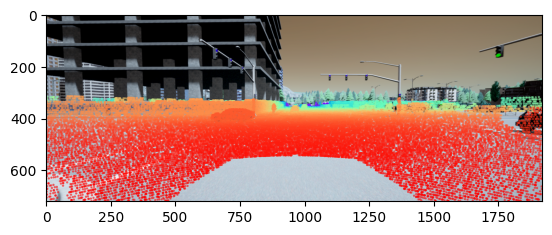

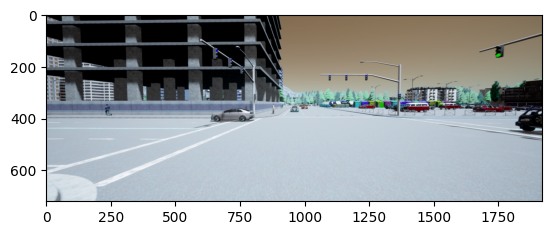

In [66]:
##                            PROJECTION OF IMAGE 0


# load the points and remove reflectance, convert to homogenous 
points = velo_pointcloud[:, 0:3]
velo = np.insert(points,3,1,axis=1).T

# for back image remove the positive x values 
velo = np.delete(velo,np.where(velo[0,:]>0),axis=1)

# convert the velo point to the p2 reference 
P2_ref_points = Tr_rect.dot(velo)

# now project the points onto camera 0
cam_0_points = P_0.dot(P2_ref_points)
# for back camera remove the points that have -ve z values 
filtered_cam_0_pts = np.delete(cam_0_points,np.where(cam_0_points[2,:]<0),axis=1)

# convert into integer and round the values 
width, height, _ = image_0.shape
depth = filtered_cam_0_pts[2,:]
filtered_cam_0_pts = filtered_cam_0_pts/filtered_cam_0_pts[2,:]
filtered_cam_0_pts = np.round(filtered_cam_0_pts.T, 0)[:,:].astype("int")
# select the points that lie in the image size 
indices = np.where((filtered_cam_0_pts[:,0]<height)&(filtered_cam_0_pts[:,0]>=0)&(filtered_cam_0_pts[:,1]<width)&(filtered_cam_0_pts[:,1]>=0))
pixel_coordinates = filtered_cam_0_pts[indices]
depth = depth[indices]
# overlay the image and points 
plt.figure()
plt.imshow(image_0)
plt.scatter(pixel_coordinates[:,0],pixel_coordinates[:,1],c=depth,cmap='rainbow_r',alpha=0.5,s=0.5)
plt.show()
plt.figure()
plt.imshow(image_0)
plt.show()

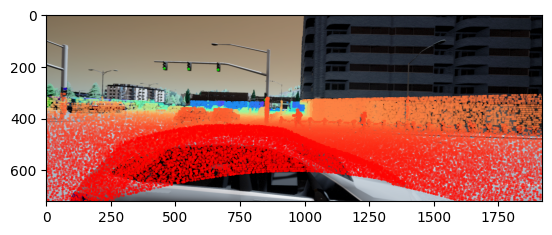

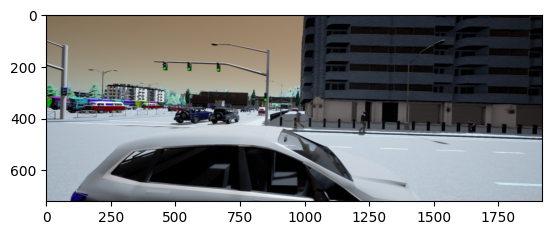

In [63]:
##                            PROJECTION OF IMAGE 1


# load the points and remove reflectance, convert to homogenous 
points = velo_pointcloud[:, 0:3]
velo = np.insert(points,3,1,axis=1).T

# for left image remove the negativv y values 
velo = np.delete(velo,np.where(velo[1,:]<0),axis=1)

# convert the velo point to the p2 reference 
P2_ref_points = Tr_rect.dot(velo)

# now project the points onto camera 0
cam_1_points = P_1.dot(P2_ref_points)
# for left camera remove the points that have -ve z values 
filtered_cam_1_pts = np.delete(cam_1_points,np.where(cam_1_points[2,:]<0),axis=1)

# convert into integer and round the values 
width, height, _ = image_1.shape
depth = filtered_cam_1_pts[2,:]
filtered_cam_1_pts = filtered_cam_1_pts/filtered_cam_1_pts[2,:]
filtered_cam_1_pts = np.round(filtered_cam_1_pts.T, 0)[:,:].astype("int")
# select the points that lie in the image size 
indices = np.where((filtered_cam_1_pts[:,0]<height)&(filtered_cam_1_pts[:,0]>=0)&(filtered_cam_1_pts[:,1]<width)&(filtered_cam_1_pts[:,1]>=0))
pixel_coordinates = filtered_cam_1_pts[indices]

depth = depth[indices]
# overlay the image and points 
plt.figure()
plt.imshow(image_1)
plt.scatter(pixel_coordinates[:,0],pixel_coordinates[:,1],c=depth,cmap='rainbow_r',alpha=0.5,s=0.5)
plt.show()
plt.figure()
plt.imshow(image_1)
plt.show()

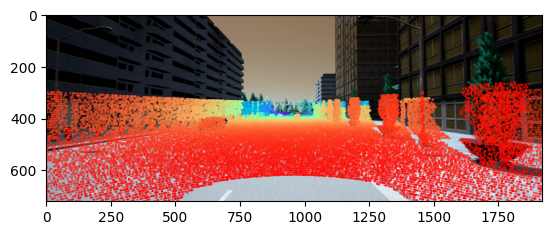

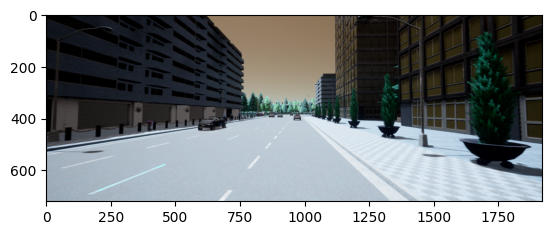

In [62]:
##                            PROJECTION OF IMAGE 2


# load the points and remove reflectance, convert to homogenous 
points = velo_pointcloud[:, 0:3]
velo = np.insert(points,3,1,axis=1).T

# for left image remove the negativv x values 
velo = np.delete(velo,np.where(velo[0,:]<0),axis=1)

# convert the velo point to the p2 reference 
P2_ref_points = Tr_rect.dot(velo)

# now project the points onto camera 0
cam_2_points = P_2.dot(P2_ref_points)
# for left camera remove the points that have -ve z values 
filtered_cam_2_pts = np.delete(cam_2_points,np.where(cam_2_points[2,:]<0),axis=1)

# convert into integer and round the values 
width, height, _ = image_2.shape
depth = filtered_cam_2_pts[2,:]
filtered_cam_2_pts = filtered_cam_2_pts/filtered_cam_2_pts[2,:]
filtered_cam_2_pts = np.round(filtered_cam_2_pts.T, 0)[:,:].astype("int")
# select the points that lie in the image size 
indices = np.where((filtered_cam_2_pts[:,0]<height)&(filtered_cam_2_pts[:,0]>=0)&(filtered_cam_2_pts[:,1]<width)&(filtered_cam_2_pts[:,1]>=0))
pixel_coordinates = filtered_cam_2_pts[indices]

depth = depth[indices]
# overlay the image and points 
plt.figure()
plt.imshow(image_2)
plt.scatter(pixel_coordinates[:,0],pixel_coordinates[:,1],c=depth,cmap='rainbow_r',alpha=0.5,s=0.5)
plt.show()
plt.figure()
plt.imshow(image_2)
plt.show()

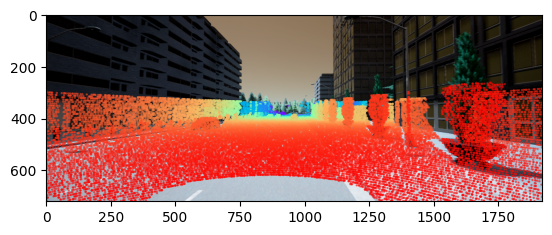

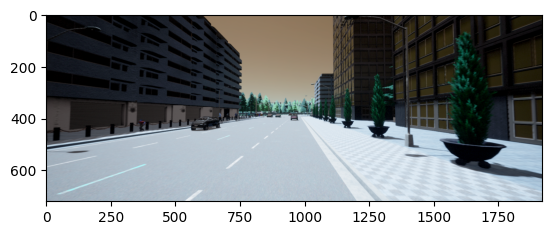

In [61]:
##                            PROJECTION OF IMAGE 3


# load the points and remove reflectance, convert to homogenous 
points = velo_pointcloud[:, 0:3]
velo = np.insert(points,3,1,axis=1).T

# for left image remove the negativv x values 

# convert the velo point to the p2 reference 
P2_ref_points = Tr_rect.dot(velo)

# now project the points onto camera 0
cam_3_points = P_3.dot(P2_ref_points)
# for left camera remove the points that have -ve z values 
filtered_cam_3_pts = np.delete(cam_3_points,np.where(cam_3_points[2,:]<0),axis=1)

# convert into integer and round the values 
width, height, _ = image_3.shape
depth = filtered_cam_3_pts[2,:]
filtered_cam_3_pts = filtered_cam_3_pts/filtered_cam_3_pts[2,:]
filtered_cam_3_pts = np.round(filtered_cam_3_pts.T, 0)[:,:].astype("int")
# select the points that lie in the image size 
indices = np.where((filtered_cam_3_pts[:,0]<height)&(filtered_cam_3_pts[:,0]>=0)&(filtered_cam_3_pts[:,1]<width)&(filtered_cam_3_pts[:,1]>=0))
pixel_coordinates = filtered_cam_3_pts[indices]

depth = depth[indices]
# overlay the image and points 
plt.figure()
plt.imshow(image_3)
plt.scatter(pixel_coordinates[:,0],pixel_coordinates[:,1],c=depth,cmap='rainbow_r',alpha=0.5,s=0.5)
plt.show()
plt.figure()
plt.imshow(image_3)
plt.show()

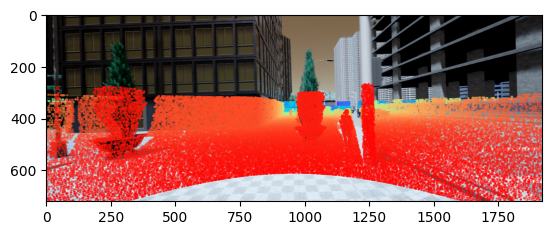

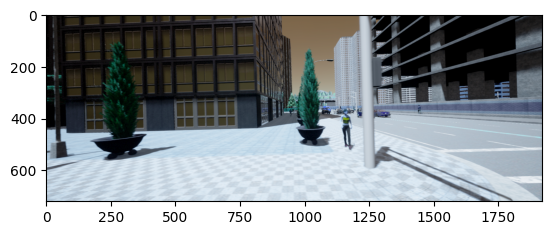

In [60]:
##                            PROJECTION OF IMAGE 4


# load the points and remove reflectance, convert to homogenous 
points = velo_pointcloud[:, 0:3]
velo = np.insert(points,3,1,axis=1).T

# for right image remove the negativv x values 
velo = np.delete(velo,np.where(velo[1,:]>0),axis=1)

# convert the velo point to the p2 reference 
P2_ref_points = Tr_rect.dot(velo)

# now project the points onto camera 0
cam_4_points = P_4.dot(P2_ref_points)
# for left camera remove the points that have -ve z values 
filtered_cam_4_pts = np.delete(cam_4_points,np.where(cam_4_points[2,:]<0),axis=1)

# convert into integer and round the values 
width, height, _ = image_4.shape
depth = filtered_cam_4_pts[2,:]
filtered_cam_4_pts = filtered_cam_4_pts/filtered_cam_4_pts[2,:]
filtered_cam_4_pts = np.round(filtered_cam_4_pts.T, 0)[:,:].astype("int")
# select the points that lie in the image size 
indices = np.where((filtered_cam_4_pts[:,0]<height)&(filtered_cam_4_pts[:,0]>=0)&(filtered_cam_4_pts[:,1]<width)&(filtered_cam_4_pts[:,1]>=0))
pixel_coordinates = filtered_cam_4_pts[indices]

depth = depth[indices]
# overlay the image and points 
plt.figure()
plt.imshow(image_4)
plt.scatter(pixel_coordinates[:,0],pixel_coordinates[:,1],c=depth,cmap='rainbow_r',alpha=0.5,s=0.5)
plt.show()
plt.figure()
plt.imshow(image_4)
plt.show()

# BOUNDING BOX PROJECTION 


In [4]:
import pickle 


In [5]:
with open('box_000001.pkl', 'rb') as f:
    data = pickle.load(f, encoding="bytes")

In [11]:
corner_pts = data[b"fr_cam"][249]
corner_pts = np.insert(corner_pts,3,1,axis=1).T
corner_pts_cam = P_4.dot(corner_pts)
corner_pts_cam = corner_pts_cam/corner_pts_cam[2,:]
corner_pts_cam = np.round(corner_pts_cam.T, 0)[:,:].astype("int")
box_3d = corner_pts_cam*1
print(box_3d.shape)
print(box_3d)

(8, 3)
[[1192  521    1]
 [1148  519    1]
 [1142  506    1]
 [1182  507    1]
 [1187  355    1]
 [1143  356    1]
 [1137  356    1]
 [1178  355    1]]


In [31]:
#plt.figure()
#plt.plot(x1, y1, x2, y2)
#plt.plot(box_3d[4,0], box_3d[4,1], box_3d[6,0],box_3d[6,1])
#plt.plot(box_3d[0,0], box_3d[0,1], box_3d[4,0],box_3d[4,1])
#plt.plot(box_3d[2,0], box_3d[2,1], box_3d[6,0],box_3d[6,1])
#plt.plot(box_3d[1,0], box_3d[1,1], box_3d[3,0],box_3d[3,1])
#plt.plot(box_3d[1,0], box_3d[1,1], box_3d[5,0],box_3d[5,1])
#plt.plot(box_3d[7,0], box_3d[7,1], box_3d[3,0],box_3d[3,1])
#plt.plot(box_3d[7,0], box_3d[7,1], box_3d[5,0],box_3d[5,1])
#plt.plot(box_3d[0,0], box_3d[0,1], marker='v', color="red")
image_4 = cv2.imread("image4_000001.png",1)
cv2.line(image_4, (box_3d[0,0], box_3d[0,1]), (box_3d[3,0], box_3d[3,1]), (0, 255, 0), thickness=2) #green
cv2.line(image_4, (box_3d[0,0], box_3d[0,1]), (box_3d[4,0], box_3d[4,1]), (0, 255, 0), thickness=2)
cv2.line(image_4, (box_3d[2,0], box_3d[2,1]), (box_3d[6,0], box_3d[6,1]), (0, 255, 0), thickness=2)# white
cv2.line(image_4, (box_3d[1,0], box_3d[1,1]), (box_3d[2,0], box_3d[2,1]), (0, 255, 0), thickness=2) #black
cv2.line(image_4, (box_3d[1,0], box_3d[1,1]), (box_3d[5,0], box_3d[5,1]), (0, 255, 0), thickness=2)
cv2.line(image_4, (box_3d[7,0], box_3d[7,1]), (box_3d[3,0], box_3d[3,1]), (0, 255, 0), thickness=2)
cv2.line(image_4, (box_3d[1,0], box_3d[1,1]), (box_3d[0,0], box_3d[0,1]), (0, 255, 0), thickness=2)
cv2.line(image_4, (box_3d[2,0], box_3d[2,1]), (box_3d[3,0], box_3d[3,1]), (0, 255, 0), thickness=2)
cv2.line(image_4, (box_3d[6,0], box_3d[6,1]), (box_3d[5,0], box_3d[5,1]), (0, 255, 0), thickness=2) # w-c
cv2.line(image_4, (box_3d[5,0], box_3d[5,1]), (box_3d[4,0], box_3d[4,1]), (0, 255, 0), thickness=2) # c-b
cv2.line(image_4, (box_3d[4,0], box_3d[4,1]), (box_3d[7,0], box_3d[7,1]), (0, 255, 0), thickness=2) # y-b
cv2.line(image_4, (box_3d[7,0], box_3d[7,1]), (box_3d[6,0], box_3d[6,1]), (0, 255, 0), thickness=2) # y-w



cv2.imshow("foo",image_4)
k = cv2.waitKey(0)
if k == 27:  # close on ESC key
    cv2.destroyAllWindows()
#cv2.waitKey()
#plt.imshow(image_4)

#plt.show()

# x1, y1, x2, y2
# 312 338 548 3515
x,y,z =  0.5799, 7.7732, 1.8663
patch = image_4[356:519,1135:1185]

#plt.imshow(patch)

#plt.show()

In [156]:
# test
# x y z l w h theta
x,y,z =  0.4880, 1.9158, 0.5799#1.9158, 0.4880, 0.5799#0.4880, 0.5799, 7.7732#1.9158,0.4880,0.5799
# now project this on 2d image 
# image 4 
point = np.asarray([x,y,z,1]).reshape(4,1)
P2_ref_point = Tr_rect.dot(point)
cam_4_point = P_4.dot(P2_ref_point)
print(cam_4_point)
normalized_pt = cam_4_point/cam_4_point[2,0]
rounded_pt = np.round(normalized_pt, 0).astype("int")
print(rounded_pt)

[[-3.10248448e+03]
 [-1.66071337e+03]
 [-2.94580000e+00]]
[[1053]
 [ 564]
 [   1]]


In [ ]:
1135.90 356.60 1185.10 519.40
x1       y1     x2     y2 
1160
437.5


In [149]:
campt = np.asarray([1160, 437.5, 1, 1]).reshape(4,1)
p4_udt = np.insert(P_4,3,[0,0,0,1], axis=0)

p4_inv = np.linalg.inv(p4_udt)
tr_inv = np.linalg.inv(Tr_rect)
point = tr_inv.dot(p4_inv.dot(campt))
print(point)

[[-0.36812615]
 [-2.03      ]
 [-0.64285714]
 [ 1.        ]]


In [75]:
# load all the label txt files and crop out the specific block (columns 11,12,13)
label_list = []
filter_list = []


label_0 = pd.read_csv("label_0_000001.txt",delimiter=' ',header=None) 
block_0 = np.asarray(label_0.iloc[:,11:15])
filter_block_0 = np.asarray(label_0.iloc[:,1:3])
label_list.append(block_0)
filter_list.append(filter_block_0)
label_1 = pd.read_csv("label_1_000001.txt",delimiter=' ',header=None) 
block_1 = np.asarray(label_1.iloc[:,11:15])
filter_block_1 = np.asarray(label_1.iloc[:,1:3])
label_list.append(block_1)
filter_list.append(filter_block_1)
label_2 = pd.read_csv("label_2_000001.txt",delimiter=' ',header=None) 
block_2 = np.asarray(label_2.iloc[:,11:15])
filter_block_2 = np.asarray(label_2.iloc[:,1:3])
label_list.append(block_2)
filter_list.append(filter_block_2)
label_3 = pd.read_csv("label_3_000001.txt",delimiter=' ',header=None) 
block_3 = np.asarray(label_3.iloc[:,11:15])
filter_block_3 = np.asarray(label_3.iloc[:,1:3])
label_list.append(block_3)
filter_list.append(filter_block_3)
label_4 = pd.read_csv("label_4_000001.txt",delimiter=' ',header=None) 
block_4 = np.asarray(label_4.iloc[:,11:15])
filter_block_4 = np.asarray(label_4.iloc[:,1:3])
label_list.append(block_4)
filter_list.append(filter_block_4)

print(label_list[0].shape)

(513, 4)


In [105]:
# load the box corrdinates 
with open('box_000001.pkl', 'rb') as f:
    data = pickle.load(f, encoding="bytes")
box_coor = data[b"fr_cam"]


In [77]:
# draw bounding box with filter  
# define the "not" template 
not_template = [-1000.00, -1000.00, -1000.00, -1000.00]
filter_template = [0.00, 0.00]
# define box coordinate list for each image
box_0 = []
box_1 = []
box_2 = []
box_3 = []
box_4 = []

# iterate over each box and check which image it belongs and store it accordingly 
for box in box_coor:
    
    if (not np.sum(not_template==label_list[0][box,:])) and ((filter_list[0][box,0]==0)and(filter_list[0][box,1]<1)):
        box_0.append(box_coor[box])
    if (not np.sum(not_template==label_list[1][box,:])) and ((filter_list[1][box,0]==0)and(filter_list[1][box,1]<1)):
        box_1.append(box_coor[box])
    if (not np.sum(not_template==label_list[2][box,:])) and ((filter_list[2][box,0]==0)and(filter_list[2][box,1]<1)):
        box_2.append(box_coor[box])
    if (not np.sum(not_template==label_list[3][box,:])) and ((filter_list[3][box,0]==0)and(filter_list[3][box,1]<1)):
        box_3.append(box_coor[box])
    if (not np.sum(not_template==label_list[4][box,:])) and ((filter_list[4][box,0]==0)and(filter_list[4][box,1]<1)):
        box_4.append(box_coor[box])
    

In [61]:
# draw bounding box without filter 
# define the "not" template 
not_template = [-1000.00, -1000.00, -1000.00, -1000.00]

# define box coordinate list for each image
box_0 = []
box_1 = []
box_2 = []
box_3 = []
box_4 = []

# iterate over each box and check which image it belongs and store it accordingly 
for box in box_coor:
    
    if not np.sum(not_template==label_list[0][box,:]):
        box_0.append(box_coor[box])
    if not np.sum(not_template==label_list[1][box,:]):
        box_1.append(box_coor[box])
    if not np.sum(not_template==label_list[2][box,:]):
        box_2.append(box_coor[box])
    if not np.sum(not_template==label_list[3][box,:]):
        box_3.append(box_coor[box])
    if not np.sum(not_template==label_list[4][box,:]):
        box_4.append(box_coor[box])
    

In [78]:
# loop over each image and plot corresponding boxes 

# create a bounding box plotting function 
def create_box(image, projection_mat, box_list):
    for box in box_list:
        # get the corner coordinates in the camera frame 
        corner_pts = np.insert(box,3,1,axis=1).T
        corner_pts_cam = projection_mat.dot(corner_pts)
        corner_pts_cam = corner_pts_cam/corner_pts_cam[2,:]
        corner_pts_cam = np.round(corner_pts_cam.T, 0)[:,:].astype("int")
        box_3d = corner_pts_cam*1
        
        # plot the bounding box on the image 
        cv2.line(image, (box_3d[0,0], box_3d[0,1]), (box_3d[3,0], box_3d[3,1]), (0, 255, 0), thickness=2) #green
        cv2.line(image, (box_3d[0,0], box_3d[0,1]), (box_3d[4,0], box_3d[4,1]), (0, 255, 0), thickness=2)
        cv2.line(image, (box_3d[2,0], box_3d[2,1]), (box_3d[6,0], box_3d[6,1]), (0, 255, 0), thickness=2)# white
        cv2.line(image, (box_3d[1,0], box_3d[1,1]), (box_3d[2,0], box_3d[2,1]), (0, 255, 0), thickness=2) #black
        cv2.line(image, (box_3d[1,0], box_3d[1,1]), (box_3d[5,0], box_3d[5,1]), (0, 255, 0), thickness=2)
        cv2.line(image, (box_3d[7,0], box_3d[7,1]), (box_3d[3,0], box_3d[3,1]), (0, 255, 0), thickness=2)
        cv2.line(image, (box_3d[1,0], box_3d[1,1]), (box_3d[0,0], box_3d[0,1]), (0, 255, 0), thickness=2)
        cv2.line(image, (box_3d[2,0], box_3d[2,1]), (box_3d[3,0], box_3d[3,1]), (0, 255, 0), thickness=2)
        cv2.line(image, (box_3d[6,0], box_3d[6,1]), (box_3d[5,0], box_3d[5,1]), (0, 255, 0), thickness=2) # w-c
        cv2.line(image, (box_3d[5,0], box_3d[5,1]), (box_3d[4,0], box_3d[4,1]), (0, 255, 0), thickness=2) # c-b
        cv2.line(image, (box_3d[4,0], box_3d[4,1]), (box_3d[7,0], box_3d[7,1]), (0, 255, 0), thickness=2) # y-b
        cv2.line(image, (box_3d[7,0], box_3d[7,1]), (box_3d[6,0], box_3d[6,1]), (0, 255, 0), thickness=2) # y-w
        
    return image

# display the bounding boxes for image_0
image_0 = cv2.imread("image0_000001.png",1)
annotated_image_0 = create_box(image_0, P_0, box_0)
# save the image 
cv2.imwrite("annotated_image_0.jpg",annotated_image_0)

# display the bounding boxes for image_1
image_1 = cv2.imread("image1_000001.png",1)
annotated_image_1 = create_box(image_1, P_1, box_1)
# save the image 
cv2.imwrite("annotated_image_1.jpg",annotated_image_1)

# display the bounding boxes for image_2
image_2 = cv2.imread("image2_000001.png",1)
annotated_image_2 = create_box(image_2, P_2, box_2)
# save the image 
cv2.imwrite("annotated_image_2.jpg",annotated_image_2)

# display the bounding boxes for image_3
image_3 = cv2.imread("image3_000001.png",1)
annotated_image_3 = create_box(image_3, P_3, box_3)
# save the image 
cv2.imwrite("annotated_image_3.jpg",annotated_image_3)

# display the bounding boxes for image_4
image_4 = cv2.imread("image4_000001.png",1)
annotated_image_4 = create_box(image_4, P_4, box_4)
# save the image 
cv2.imwrite("annotated_image_4.jpg",annotated_image_4)



#cv2.imshow("image_0",annotated_image_0)
#k = cv2.waitKey(0)
#if k == 27:  
#    cv2.destroyAllWindows()
    

True

# 3d bounding box on 2d images  


In [5]:
import os


calib = pd.read_csv("/home/divyanshu/3d_detection/AIO/aiodrive_calibration_mini/calib/000001.txt",delimiter=' ',header=None, index_col=0)
P_0 = np.array(calib.iloc[0]).reshape((3,4)).round(2)
P_1 = np.array(calib.iloc[1]).reshape((3,4)).round(2)
P_2 = np.array(calib.iloc[2]).reshape((3,4)).round(2)
P_3 = np.array(calib.iloc[3]).reshape((3,4)).round(2)
P_4 = np.array(calib.iloc[4]).reshape((3,4)).round(2)
P_5 = np.array(calib.iloc[5]).reshape((3,4)).round(2)
#R_0 = np.nan_to_num(np.array(calib.iloc[6]).reshape((3,3)).round(2), nan=0.0)
Tr = np.array(calib.iloc[7]).reshape((3,4)).round(2)
P2_to_w = np.array(calib.iloc[9]).reshape((3,4)).round(2)

R_0_rect = np.diag([1,1,1,1])#np.insert(R_0,3,values=[0,0,0,1],axis=0)
Tr_rect = np.insert(Tr,3,values=[0,0,0,1],axis=0)
p_2_to_w = np.insert(P2_to_w,3,values=[0,0,0,1],axis=0)

In [128]:
path  = "/home/divyanshu/3d_detection/AIO/aiodrive_calibration_mini/velocorr"
files = []

for filename in os.listdir(path):
    files.append(filename)

files.sort()

with open(os.path.join(path, files[0]), 'rb') as f:
    frame_projection_mat = pickle.load(f, encoding="bytes")
    
print(frame_projection_mat[249])

[[ 9.99999999e-01 -1.48573050e-05 -3.48634520e-05 -3.28772270e-02]
 [ 1.48572465e-05  1.00000000e+00 -1.67884642e-06  4.61783250e-04]
 [ 3.48634769e-05  1.67832844e-06  9.99999999e-01  6.52556588e-04]
 [-3.88578059e-16  0.00000000e+00 -2.77555756e-17  1.00000000e+00]]


In [63]:
velo_path = "/home/divyanshu/3d_detection/AIO/aiodrive_lidar_velodyne_mini/lidar_velodyne"

velo_frame_1 = np.fromfile(os.path.join(velo_path,"000001.bin"), dtype=np.float32).reshape((-1,4))
velo_frame_2 = np.fromfile(os.path.join(velo_path,"000002.bin"), dtype=np.float32).reshape((-1,4))

In [19]:
"""
# load the points and remove reflectance, convert to homogenous 
points_1 = velo_frame_1[:, 0:3]
velo_1 = np.insert(points_1,3,1,axis=1).T

# for right image remove the negativv x values 
velo_1 = np.delete(velo_1,np.where(velo_1[1,:]>0),axis=1)

# load the points and remove reflectance, convert to homogenous 
points_2 = velo_frame_2[:, 0:3]
velo_2 = np.insert(points_2,3,1,axis=1).T

# for right image remove the negativv x values 
velo_2 = np.delete(velo_2,np.where(velo_2[1,:]>0),axis=1)
"""

In [129]:
# select the pesestrian bounding box from image4 and collect all the lidar points in that box 
with open('/home/divyanshu/3d_detection/AIO/aiodrive_boxes_mini/box/000000.pkl', 'rb') as f:
    data = pickle.load(f, encoding="bytes")
corner_pts = data[b"lidar"][249]
corner_pts = np.insert(corner_pts,3,1,axis=1)

# use the velo corr matrix to project the points from frame one to frame 2 
corner_pts = frame_projection_mat[249].dot(corner_pts.T)
corner_pts = Tr_rect.dot(corner_pts)
cam_4_point = P_4.dot(corner_pts)
normalized_pt = cam_4_point/cam_4_point[2,:]
rounded_pt = np.round(normalized_pt, 0).astype("int").T
box_3d = rounded_pt*1
print(box_3d.shape)

(8, 3)


In [130]:
# load the second image 
image_4_2 = cv2.imread(os.path.join("/home/divyanshu/3d_detection/AIO/aiodrive_image_mini/image_4","000002.png"),1)
image_4_1 = cv2.imread(os.path.join("/home/divyanshu/3d_detection/AIO/aiodrive_image_mini/image_4","000001.png"),1)
image_4_0 = cv2.imread(os.path.join("/home/divyanshu/3d_detection/AIO/aiodrive_image_mini/image_4","000000.png"),1)
image_4_3 = cv2.imread(os.path.join("/home/divyanshu/3d_detection/AIO/aiodrive_image_mini/image_4","000003.png"),1)

cv2.line(image_4_1, (box_3d[0,0], box_3d[0,1]), (box_3d[3,0], box_3d[3,1]), (0, 255, 0), thickness=2) #green
cv2.line(image_4_1, (box_3d[0,0], box_3d[0,1]), (box_3d[4,0], box_3d[4,1]), (0, 255, 0), thickness=2)
cv2.line(image_4_1, (box_3d[2,0], box_3d[2,1]), (box_3d[6,0], box_3d[6,1]), (0, 255, 0), thickness=2)# white
cv2.line(image_4_1, (box_3d[1,0], box_3d[1,1]), (box_3d[2,0], box_3d[2,1]), (0, 255, 0), thickness=2) #black
cv2.line(image_4_1, (box_3d[1,0], box_3d[1,1]), (box_3d[5,0], box_3d[5,1]), (0, 255, 0), thickness=2)
cv2.line(image_4_1, (box_3d[7,0], box_3d[7,1]), (box_3d[3,0], box_3d[3,1]), (0, 255, 0), thickness=2)
cv2.line(image_4_1, (box_3d[1,0], box_3d[1,1]), (box_3d[0,0], box_3d[0,1]), (0, 255, 0), thickness=2)
cv2.line(image_4_1, (box_3d[2,0], box_3d[2,1]), (box_3d[3,0], box_3d[3,1]), (0, 255, 0), thickness=2)
cv2.line(image_4_1, (box_3d[6,0], box_3d[6,1]), (box_3d[5,0], box_3d[5,1]), (0, 255, 0), thickness=2) # w-c
cv2.line(image_4_1, (box_3d[5,0], box_3d[5,1]), (box_3d[4,0], box_3d[4,1]), (0, 255, 0), thickness=2) # c-b
cv2.line(image_4_1, (box_3d[4,0], box_3d[4,1]), (box_3d[7,0], box_3d[7,1]), (0, 255, 0), thickness=2) # y-b
cv2.line(image_4_1, (box_3d[7,0], box_3d[7,1]), (box_3d[6,0], box_3d[6,1]), (0, 255, 0), thickness=2) # y-w

cv2.imshow("projected bounding box",image_4_1)
k = cv2.waitKey(0)
if k == 27:  # close on ESC key
    cv2.destroyAllWindows()



# LIDAR DATA SAMPLING 

In [202]:
# load the lidar data 
velo_path = "/home/divyanshu/3d_detection/AIO/aiodrive_lidar_velodyne_mini/lidar_velodyne"

velo_frame_1 = np.fromfile(os.path.join(velo_path,"000003.bin"), dtype=np.float32).reshape((-1,4))
#velo_frame_2 = np.fromfile(os.path.join(velo_path,"000002.bin"), dtype=np.float32).reshape((-1,4))


# load the points and remove reflectance, convert to homogenous 
points_1 = velo_frame_1[:, 0:3]
velo_1 = np.insert(points_1,3,1,axis=1).T


In [203]:
x = velo_1[0,:]
y = velo_1[1,:]
z = velo_1[2,:]

# convert cartesian coordinates into spherical coordinates and calculate chi
angles = np.arccos((z/np.sqrt(x*x + y*y + z*z)))
print(np.min(angles), np.max(angles))

1.5358796 1.9984581


In [204]:
# divide the range into bins 
# take 20 bins 
max_bins = 64
bin_value = (np.max(angles) - np.min(angles))/64
bins_AIO = []
start = np.min(angles)
bins_AIO.append(start)
for i in range(max_bins):
    start = start + bin_value
    bins_AIO.append(start)


In [205]:
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points_1)

o3d.visualization.draw_geometries([point_cloud])

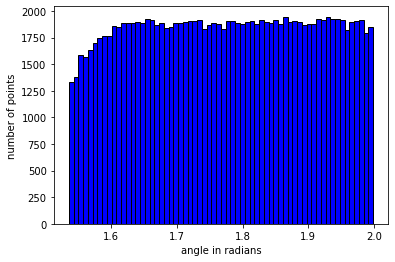

In [206]:
counts, bins, bars = plt.hist(angles, bins = bins_AIO,
             color = 'blue', edgecolor = 'black')#plt.hist(angles,bins=bins)
plt.xlabel("angle in radians")
plt.ylabel("number of points")
plt.show()

## sparsify the data evenly 

In [13]:
# get the data from histogram 

index = []
for i in range(max_bins-1):
    index.append(np.where((angles>=bins[i])&(angles<bins[i+1])))
    



In [14]:
# now select the 50 percentage randomly from each bin 

filtered_index = []
for i in range(len(index)):
        filtered_index.append(np.random.choice(index[i][0], size=int(0.5*len(index[i][0]))))
        


In [15]:
# now merge all the indexes and select the respective point from point cloud 

half_point_index = list(filtered_index[0])
for a in filtered_index[1:]:
    half_point_index = list(half_point_index) + list(a)
    
np.sort(half_point_index)


array([     2,      3,      3, ..., 117029, 117029, 117031])

In [16]:
#print(velo_1.T[half_point_index].shape)
half_point_cloud = velo_1.T[half_point_index][:,:3]
print(half_point_cloud.shape)
print(velo_1.T.shape)

(58500, 3)
(118985, 4)


## convert from 64 to 32 beams 

In [17]:
# use the histogram data (index array) as it is from above 

point_cloud_32_index = list(index[1][0])

for i, indexes in enumerate(index):
    if(i%2)&(i>2):
        point_cloud_32_index = list(point_cloud_32_index) + list(indexes[0])
        
np.sort(point_cloud_32_index)


        

array([  1412,   1413,   1414, ..., 115152, 115153, 115154])

In [18]:
point_cloud_32 = velo_1.T[point_cloud_32_index][:,:3]
print(point_cloud_32.shape)

(57704, 3)


## convert from 62 to 16

In [19]:
# use the histogram data (index array) as it is from above 

point_cloud_index_16 = list(index[1][0])

for i, indexes in enumerate(index):
    if(i%2)&(i>2):
        point_cloud_index_16 = list(point_cloud_index_16) + list(indexes[0])
        
np.sort(point_cloud_index_16)



        

array([  1412,   1413,   1414, ..., 115152, 115153, 115154])

In [155]:
point_cloud_16_beam = velo_1.T[point_cloud_32_index][:,:3]
print(point_cloud_16_beam.shape)

(57704, 3)


In [21]:
# save the point cloud in all 3 formats 

# 64 beam cloud 
velo_1.T.astype(np.float32).tofile("CMU_AIO_64.bin")
print(velo_1.T.reshape((-1,)).shape)

# 32 beam cloud 
bin_32 = np.insert(point_cloud_32,3,1,axis=1)
bin_32.astype(np.float32).tofile("CMU_AIO_32.bin")
print(bin_32.reshape((-1,)).shape)

 




(475940,)
(230816,)


[ 0.0503 27.5311  0.9614 ...  2.7372 -1.2474  0.9881]


In [156]:
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(point_cloud_16_beam)

o3d.visualization.draw_geometries([point_cloud])

## calculation of angles on cepton lidar data


In [185]:
pcd = o3d.io.read_point_cloud("10/110.pcd")
cepton_arr = np.asarray(pcd.points)  
#point_cloud = o3d.geometry.PointCloud()
#point_cloud.points = o3d.utility.Vector3dVector(cepton_arr)

#o3d.visualization.draw_geometries([point_cloud])

In [186]:
x = cepton_arr.T[0,:]
y = cepton_arr.T[1,:]
z = cepton_arr.T[2,:]

angles_cepton = np.arccos((z/np.sqrt(x*x + y*y + z*z)))
nan_index = ~np.isnan(angles_cepton)

filtered_cepton_arr = cepton_arr[nan_index]
filtered_angles = angles_cepton[nan_index]



/home/divyanshu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


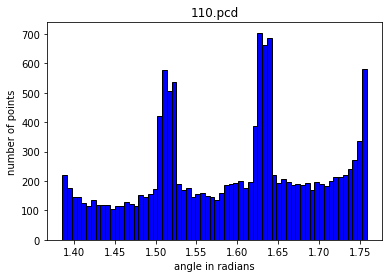

In [187]:
# plot the histogram of angles 
# divide the range into bins 
# take 64 bins 
max_bins = 64
bin_value = (np.max(filtered_angles) - np.min(filtered_angles))/64

bins = []
start = np.min(filtered_angles)
bins.append(start)
for i in range(max_bins):
    start = start + bin_value
    bins.append(start)

counts, bins, bars = plt.hist(filtered_angles, bins = bins,
             color = 'blue', edgecolor = 'black')#plt.hist(angles,bins=bins)
plt.xlabel("angle in radians")
plt.ylabel("number of points")
plt.title("110.pcd")
plt.show()


In [196]:
# calculate the ratio of each bin to capture the style of the point cloud 
total_points, _ = cepton_arr.shape
cepton_point_cloud_style = []
for count in counts:
    cepton_point_cloud_style.append(count/total_points)
    


In [213]:
# now replicate the same style in the AIO drive data
index_AIO_unfiltered = []
for i in range(max_bins):
    index_AIO_unfiltered.append(np.where((angles>=bins_AIO[i])&(angles<bins_AIO[i+1])))
    
_, total_points_AIO = velo_1.shape

index_AIO_styled_from_cepton = []
for i in range(len(index_AIO_unfiltered)):
    index_AIO_styled_from_cepton.append(np.random.choice(index_AIO_unfiltered[i][0], size=int(cepton_point_cloud_style[i]*total_points_AIO)))
        



In [215]:
AIO_styled_by_cepton_point_index = list(index_AIO_styled_from_cepton[0])
for a in index_AIO_styled_from_cepton[1:]:
    AIO_styled_by_cepton_point_index = list(AIO_styled_by_cepton_point_index) + list(a)
    
np.sort(AIO_styled_by_cepton_point_index)

array([     0,      2,      2, ..., 118350, 118350, 118352])

94133


In [118]:
# get both the angle list here 

# cepton angle list (filtered) 10/110.pcd
print(filtered_angles.shape)

# AIOdrive angle list from lidar_velodyne/000003.bin
print(angles.shape)

(14550,)
(118353,)


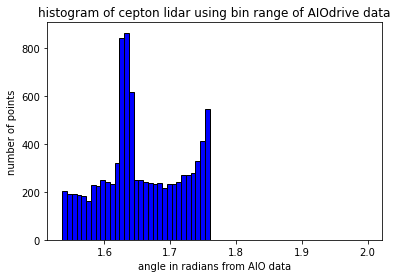

In [132]:
# plot the angles histogram for cepton using bins from AIOdrive data 

counts, bins, bars = plt.hist(filtered_angles, bins = bins_AIO,
             color = 'blue', edgecolor = 'black')#plt.hist(angles,bins=bins)
plt.xlabel("angle in radians from AIO data")
plt.ylabel("number of points")
plt.title("histogram of cepton lidar using bin range of AIOdrive data")
plt.show()

In [127]:
print(max(filtered_angles),min(filtered_angles))
print(max(angles), min(angles))

1.7579122532617777 1.3861159611765184
1.9984581 1.5358796


In [140]:
# sample the AIO lidar data from using this new histogram 

# get the point index first 

index_AIO = []
for i in range(max_bins-1):
    index_AIO.append(np.where((angles>=bins[i])&(angles<bins[i+1])))
    
# select the number of points from cepton histogram 
selected_index = []
for i in range(len(index_AIO)):
    if counts[i]!=0:
        selected_index.append(np.random.choice(index_AIO[i][0], size=int(counts[i])))
        

    


In [143]:
# filter the points based on selected index

cepton_point_index = list(selected_index[0])
for a in selected_index[1:]:
    cepton_point_index = list(cepton_point_index) + list(a)
    
np.sort(cepton_point_index)

array([    2,     4,    12, ..., 55859, 55862, 55871])

In [144]:
extracted_cepton_point_cloud = velo_1.T[cepton_point_index][:,:3]
print(extracted_cepton_point_cloud.shape)
print(velo_1.T.shape)

(9425, 3)
(118353, 4)


### do the AIO point cloud in the cepton bin and then sample 

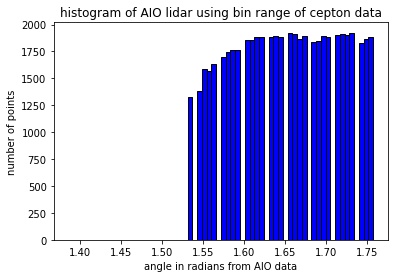

In [165]:
# AIO 
#angles
#bins_AIO

# cepton 
#bins
#filtered_angles

counts_AIO_to_cepton, _, bars = plt.hist(angles, bins = bins,
             color = 'blue', edgecolor = 'black')#plt.hist(angles,bins=bins)
plt.xlabel("angle in radians from AIO data")
plt.ylabel("number of points")
plt.title("histogram of AIO lidar using bin range of cepton data")
plt.show()



In [177]:
print(counts)

[219. 177. 146. 144. 124. 116. 134. 120. 119. 119. 106. 115. 116. 128.
 123. 116. 153. 147. 156. 173. 422. 577. 507. 535. 191. 169. 175. 147.
 157. 158. 150. 145. 137. 159. 185. 191. 194. 201. 177. 196. 388. 704.
 661. 686. 220. 194. 207. 195. 187. 188. 187. 192. 170. 196. 189. 183.
 201. 215. 213. 221. 240. 271. 336. 582.]


In [178]:
# get the data from histogram 

# get the index of AIO points from the AIO histogram projected on cepton bins 
index_AIO_to_cepton_bins = []
for i in range(max_bins-1):
    index_AIO_to_cepton_bins.append(np.where((angles>=bins[i])&(angles<bins[i+1])))

# select the number of points from cepton histogram 
selected_index_AIO_to_cepton_bins = []
for i in range(len(index_AIO_to_cepton_bins)):
    if counts_AIO_to_cepton[i]!=0:
        selected_index_AIO_to_cepton_bins.append(np.random.choice(index_AIO_to_cepton_bins[i][0], size=int(counts[i])))
        




In [179]:
AIO_to_cepton_point_index = list(selected_index_AIO_to_cepton_bins[0])
for a in selected_index_AIO_to_cepton_bins[1:]:
    AIO_to_cepton_point_index = list(AIO_to_cepton_point_index) + list(a)
    
np.sort(AIO_to_cepton_point_index)

array([   25,    28,    32, ..., 53983, 53989, 53995])

In [181]:
extracted_AIO_to_cepton_point_cloud = velo_1.T[AIO_to_cepton_point_index][:,:3]
print(extracted_AIO_to_cepton_point_cloud.shape)


(6963, 3)


(4, 118353)


In [184]:
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(extracted_AIO_to_cepton_point_cloud)

o3d.visualization.draw_geometries([point_cloud])

## do style transfer from dense lidar data in cmu AIO drive 

In [153]:
dense_path = "/home/divyanshu/3d_detection/AIO/aiodrive_lidar_denselv1_mini/lidar_denselv1"

dense_frame_1 = np.fromfile(os.path.join(dense_path,"000003.bin"), dtype=np.float32).reshape((-1,4))
#velo_frame_2 = np.fromfile(os.path.join(velo_path,"000002.bin"), dtype=np.float32).reshape((-1,4))


# load the points and remove reflectance, convert to homogenous 
dense_points_1 = dense_frame_1[:, 0:3]
dense_1 = np.insert(dense_points_1,3,1,axis=1).T


In [154]:
x = dense_1[0,:]
y = dense_1[1,:]
z = dense_1[2,:]

# convert cartesian coordinates into spherical coordinates and calculate chi
dense_angles = np.arccos((z/np.sqrt(x*x + y*y + z*z)))
print(np.min(dense_angles), np.max(dense_angles))

0.44429955 3.1415927


In [ ]:
# divide the range into bins 
# take 20 bins 
max_bins = 64
bin_value = (np.max(angles) - np.min(angles))/64
bins_AIO = []
start = np.min(angles)
bins_AIO.append(start)
for i in range(max_bins):
    start = start + bin_value
    bins_AIO.append(start)


In [183]:
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(dense_points_1)

o3d.visualization.draw_geometries([point_cloud])

In [ ]:
counts, bins, bars = plt.hist(angles, bins = bins_AIO,
             color = 'blue', edgecolor = 'black')#plt.hist(angles,bins=bins)
plt.xlabel("angle in radians")
plt.ylabel("number of points")
plt.show()